In [2]:
import RNA
import numpy as np
import matplotlib.pyplot as plt
import os

from kinetic import dict_dot_bracket, list_dot_bracket

In [3]:
def calc_MCC(prediction, ref):
    TP = 0
    FP = 0
    FN = 0
    TN = 0

    for i in range(len(prediction)):
        if ref[i] != -1:                # reference is paired
            if prediction[i] == ref[i]: # correct pair predicted
                TP += 1
            elif prediction[i] == -1:   # predicted as unpaired
                FN += 1
            else:                       # incorrect pair predicted
                FP += 1 
        elif ref[i] == -1:              # reference is unpaired
            if prediction[i] == ref[i]: # predicted as unpaired
                TN += 1
            else:                       # predicted is paired to something
                FP += 1

    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    return MCC



In [4]:
#penalize opening a base pair by a constant amount
def penalize_barriers(i, j, k, l, d, arg_dict):
    penalty = arg_dict['penalty'] # 20 is the best constant value for this.
    if d in [RNA.DECOMP_PAIR_IL, RNA.DECOMP_PAIR_HP, RNA.DECOMP_PAIR_ML]:
        ref = arg_dict['last']
        if i in ref.keys():
            if ref[i] == j:
                return 0
            else:
                return penalty
            
    return 0

# eval_move is really expensive, so pre-assemble penalties 
def get_penalties(last, fc):
    last_dict = dict_dot_bracket(last)
    out = {}
    for i, c in enumerate(last):
        if c == '(' or c == ')':
            p = min((i+1, last_dict[i+1]))
            q = max((i+1, last_dict[i+1]))
            out[i+1] = int(fc.eval_move(last, -p, -q) * 100)

    return out


#penalize opening a base pair by a percentage of the FE loss
def penalize_barriers_seq(i, j, k, l, d, arg_dict):
    if d in [RNA.DECOMP_PAIR_IL, RNA.DECOMP_PAIR_HP, RNA.DECOMP_PAIR_ML]:
        penalty_percent = arg_dict['penalty_percent']
        ref_dict = arg_dict['last_dict']
        penalty_dict = arg_dict['penalty_dict']

        if i in ref_dict.keys():
            if ref_dict[i] == j:
                return 0
            else:
                diff = penalty_dict[i]
                penalty = int(diff * penalty_percent)
                return penalty
            
    return 0 

In [5]:
from IPython.display import IFrame

# Display in a Forna iframe
def forna_display(seq, struct, cols={}):
    col_str = '\\n'.join([f'{k}:{cols[k]}' for k in cols.keys()])
    # Can we run FORNA in a notebook (I feel like I've done this before...)
    forna_src = f'http://rna.tbi.univie.ac.at/forna/forna.html?id=url/name&sequence={seq}&structure={struct}&colors={col_str}'
    #generate a unique id for our iframe
    return IFrame(forna_src, 1000, 500)
    # That was easy.

In [6]:
# Parse an rdat file into a dict with sequence and reactivities
def parse_rdat(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    data_ids = []
    data = {}

    for l in lines:
        if not l.startswith('DATA'):
            continue
        if l.startswith('DATA_ANNOTATION:'):
            if 'datatype:REACTIVITY' in l:
                l = l.split()
                id = l[0].strip('DATA_ANNOTATION:')
                data_ids.append(id)
                data[id] = {'seq' : l[1].strip('sequence:')}
        elif l.startswith('DATA:'):
            l = l.split()
            id = l[0].strip('DATA:')
            if id in data_ids:
                data[id]['react'] = [float(r) for r in l[1:]]

    # Renumber the data keys to match sequence lengths
    # This only works because the original keys are strings and new ones are ints.
    keys = list(data.keys()) # Can't del stuff in dict in a for loop over dictkeys
    for k in keys:
        data[len(data[k]['seq'])] = data[k]
        del(data[k])

    return(data)

In [7]:
shape_data = {}
rdat_files = sorted(['SRP_test/'+f for f in os.listdir('SRP_test') if 'rdat' in f])
#rdat_files = ['SRP_test/'+'SRPECLI_BZCN_0001.rdat.txt']
for r in rdat_files:
    shape_data[r.strip('SRP_test/SRPECLI_').strip('.rdat.txt')] = parse_rdat(r)

# Create dummy data with no constraints
shape_data['kinetic20'] = {}
shape_data['no_constraints'] = {}
for l in shape_data['BZCN_0001']:
    shape_data['kinetic20'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
    shape_data['no_constraints'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
#d = parse_rdat('SRP_test/SRPECLI_BZCN_0001.rdat.txt')
md = RNA.md()
md.temperature = 37

In [8]:
# Calculate folding pathways for each dataset
last_structure = ''
for n, d in shape_data.items():
    print(f'Working on {n}')
    for length in d.keys():
        subseq = d[length]['seq']
        reactivities = d[length]['react']
        # Shape-defined fold
        fc = RNA.fold_compound(subseq, md)
        if n not in ['no_constraints', 'kinetic20']:
            fc.sc_add_SHAPE_deigan(reactivities, 2.6, -0.8)
        if n == 'kinetic20':
            step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : 20
            }
            fc.sc_add_f(penalize_barriers)
            fc.sc_add_data(step_info)
        d[length]['mfe'] = fc.mfe()[0]
        last_structure = d[length]['mfe']


Working on BZCN_0001
Working on BZCN_0002
Working on BZCN_0003
Working on BZCN_0004
Working on DMS_0001
Working on DMS_0002
Working on DMS_0003
Working on kinetic20
Working on no_constraints


In [9]:
# also try drtransformer
print("Working on drtransformer")
shape_data['drtransformer'] = {}
name = 'SRP_drt'
#subprocess.run(['cat', 'SRP_test/SRP.fa', '|', 'DrTransformer' '--name', f'{name}', '--logfile'], shell=True, check=True) # this doesn't work for some reason

with open(f'SRP_test/{name}.log', 'r') as f:
    lines = f.readlines()

last_len = 0
start_len = min(list(shape_data['BZCN_0001'].keys()))
for l in lines:
    l = l.strip()
    if '#' in l:
        continue
    l = l.split()
    curr_len = int(l[0])
    if curr_len < start_len:
        continue
    if curr_len == last_len: # The MFE structure for each length if the first line with that length
        continue
    shape_data['drtransformer'][curr_len] = {
        'seq' : shape_data['BZCN_0001'][curr_len]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][curr_len]['seq']))],
        'mfe' : l[2]
    }
    last_len = curr_len

Working on drtransformer


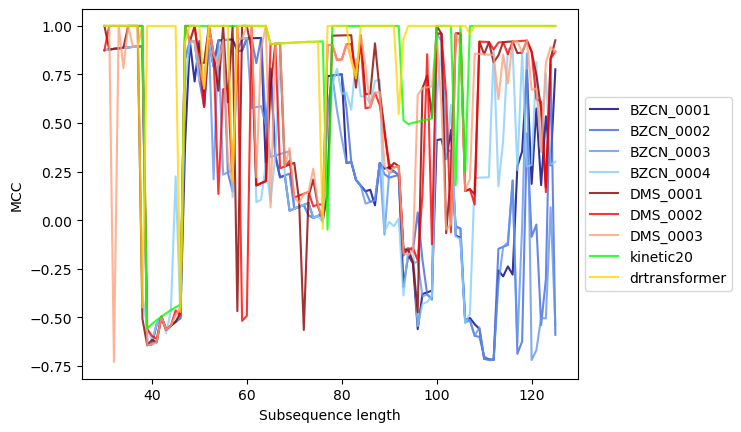

In [10]:
# Plot MCC at each length vs the no_constraints folding
# This at least tells us if if the kinetic method sees the same edges as the SHAPE data predicts
cols = {'BZCN_0001' : 'navy', 
        'BZCN_0002' : 'royalblue', 
        'BZCN_0003' : 'cornflowerblue', 
        'BZCN_0004' : 'lightskyblue', 
        'DMS_0001' : 'darkred', 
        'DMS_0002' : 'red', 
        'DMS_0003' : 'lightsalmon', 
        'kinetic20' : 'lime', 
        'drtransformer' : 'gold',
        'no_constraints' : 'black'}

fig, ax = plt.subplots()
for n, d in [it for it in list(shape_data.items()) if it[0] != 'no_constraints']:
#for n, d in [it for it in list(shape_data.items()) if it[0] != 'BZCN_0003']:
    x = list(d.keys()) # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data['no_constraints'][l]['mfe'])) for l in list(d.keys())]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

ax.set_xlabel('Subsequence length')
ax.set_ylabel('MCC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

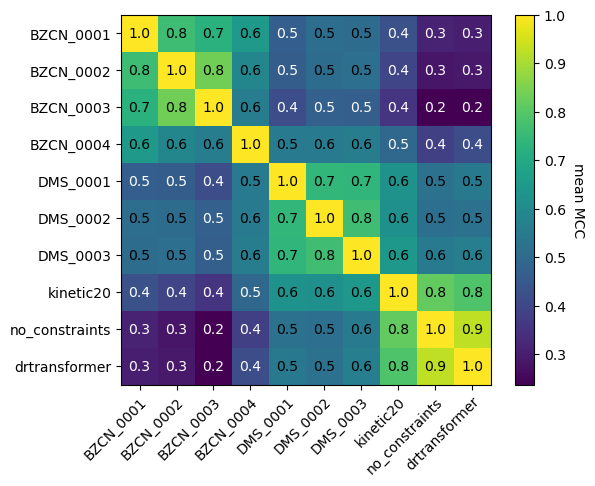

In [11]:
# plot mean MCC between different methods
fig, ax = plt.subplots()
corr = np.ones((len(shape_data.keys()), len(shape_data.keys())))
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(shape_data.items()):
        if i <= j:
            continue
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in list(d1.keys())])
        corr[i, j] = c
        corr[j, i] = c

im = ax.imshow(corr, origin='upper')
ax.set_yticks(np.arange(len(shape_data.keys())), list(shape_data.keys()))
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(corr.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(corr)):
    for j in range(len(corr)):
        kw.update(color=textcolors[int(corr[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(corr[i,j]), **kw)

plt.show()

In [12]:
# Let's try a single-value penalty sweep.  This isn't going to work, but its useful to see.

penalties = np.arange(5, 105, 5)
pred_at_pen = {}
for p in penalties:
    print("working on penalty =", p)
    pred_at_pen[p] = {}
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : int(p)
            }
        fc.sc_add_f(penalize_barriers)
        fc.sc_add_data(step_info)

        pred_at_pen[p][length] = fc.mfe()[0]
        last_structure = pred_at_pen[p][length]

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [13]:
penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_pen[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_pen[20].keys())])

In [14]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5	0.442	0.742	0.555
10	0.438	0.736	0.550
15	0.438	0.736	0.550
20	0.460	0.754	0.570
25	0.458	0.741	0.564
30	0.417	0.678	0.515
35	0.403	0.678	0.506
40	0.403	0.678	0.506
45	0.403	0.678	0.506
50	0.405	0.675	0.507
55	0.401	0.665	0.500
60	0.383	0.617	0.471
65	0.446	0.680	0.534
70	0.432	0.667	0.520
75	0.431	0.659	0.517
80	0.407	0.619	0.487
85	0.407	0.619	0.487
90	0.406	0.611	0.482
95	0.406	0.611	0.482
100	0.404	0.596	0.476

Best!
bzcn:	penalty=20 MCC=0.460
dms:	penalty=20 MCC=0.754
all:	penalty=20 MCC=0.570


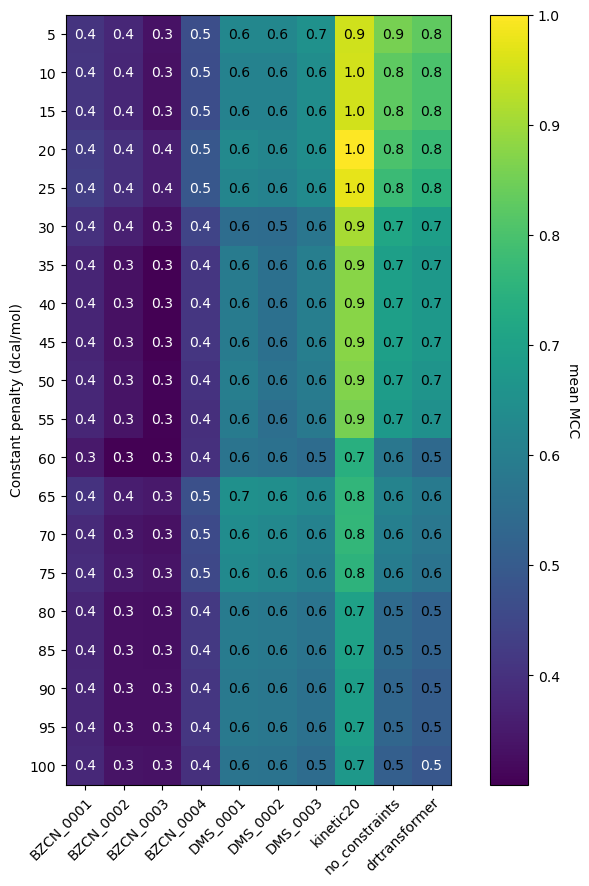

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(penalty_sweep[i, j]), **kw)

plt.show()

In [16]:
# Let's try the situation where it's dependent on the base pair broken

percents = np.arange(0.01, 0.262, 0.012)
pred_at_cent = {}
for p in percents:
    print("Working on percentage = {:.3f}".format(p), end='; ')
    pred_at_cent[p] = {}
    p_list = []
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        if last_structure != '':
            fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
            penalty_dict = get_penalties(last_structure, fc_last)
            p_list.extend([v for v in penalty_dict.values()])
        else:
            penalty_dict = {}
        step_info = {
            'last_dict' : dict_dot_bracket(last_structure),
            'penalty_dict' : penalty_dict,
            'penalty_percent' : p
            }
        fc.sc_add_f(penalize_barriers_seq)
        fc.sc_add_data(step_info)

        pred_at_cent[p][length] = fc.mfe()[0]
        last_structure = pred_at_cent[p][length]
    
    print("mean penalty = {:.0f}".format(np.mean(p_list)*p))

Working on percentage = 0.010; 

KeyboardInterrupt: 

RuntimeError: Some error occurred while executing generic soft constraint callback

In [ ]:
cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_cent[0.01].keys())])

In [ ]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.440	0.720	0.545
0.022	0.441	0.718	0.545
0.034	0.460	0.736	0.564
0.046	0.460	0.736	0.564
0.058	0.453	0.733	0.558
0.070	0.451	0.720	0.552
0.082	0.447	0.709	0.545
0.094	0.397	0.657	0.494
0.106	0.397	0.657	0.494
0.118	0.400	0.654	0.495
0.130	0.400	0.654	0.495
0.142	0.400	0.654	0.495
0.154	0.378	0.598	0.460
0.166	0.443	0.659	0.524
0.178	0.439	0.656	0.521
0.190	0.439	0.648	0.517
0.202	0.423	0.615	0.495
0.214	0.423	0.615	0.495
0.226	0.423	0.615	0.495
0.238	0.423	0.615	0.495
0.250	0.423	0.607	0.492

Best!
bzcn:	penalty=0.034 MCC=0.460
dms:	penalty=0.034 MCC=0.736
all:	penalty=0.034 MCC=0.564


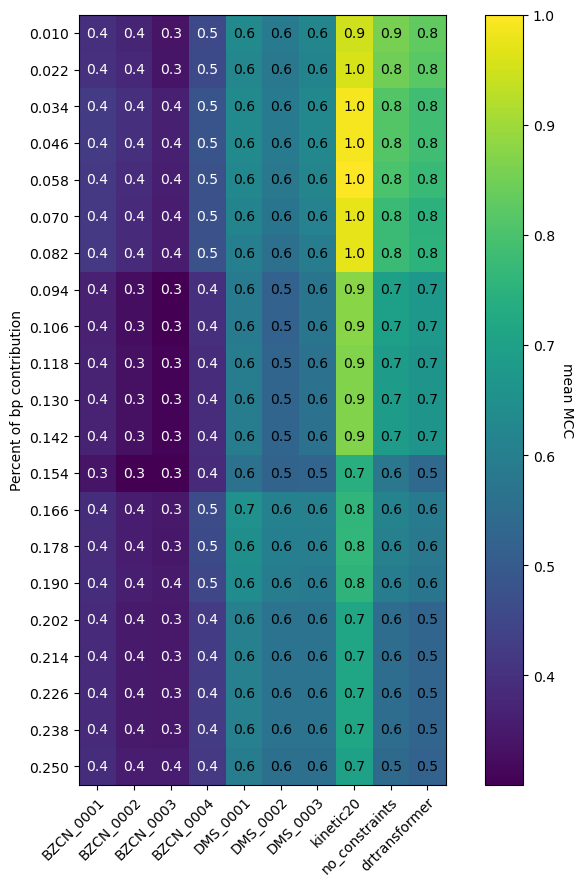

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(cent_sweep[i, j]), **kw)

plt.show()

In [ ]:
#p = .5
#last_structure = ''
#for length in shape_data['kinetic20'].keys():
#    subseq = shape_data['kinetic20'][length]['seq']
#    fc = RNA.fold_compound(subseq, md)
#    fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
#    penalty_dict = get_penalties(last_structure, fc_last)
#    step_info = {
#            'last_dict' : dict_dot_bracket(last_structure),
#            'penalty_dict' : penalty_dict,
#            'penalty_percent' : p
#        }
#    fc.sc_add_f(penalize_barriers_seq)
#    fc.sc_add_data(step_info)
#
#    out = fc.mfe()
#
#    last_structure = out[0]
#    print(out)

In [ ]:
(0.25-0.01)/20

0.012